<div align="center">
<h1 style="color:#1565c0; font-size:2.8em; font-weight:bold; margin-bottom:0.2em; margin-top:0.5em;">Практична робота №2</h1>
<h3 style="color:#1976d2; margin-top:0; font-weight:normal;">Побудова та оцiнювання якостi
моделей класифiкацiї та регресiї засобами бiблiотеки <b>Scikit-Learn Python</b></h3>
<br>
<br>
<b>Варіант 12</b><br>
<b>Автори:</b><br>
Плахтій Злата, КА-32<br>
Пастушенко Максим, КА-33<br>
Романов Фелікс, КА-33
</div>

<b>Мета:</b> Метою роботи є побудова та оцiнювання якостi моделей:
- дерев рiшень,
- опорних векторiв,
- логiстичної регресiї,
- наївної баєсiвської моделi
для класифiкацiї та регресiї засобами бiблiотеки Scikit-Learn Python.

<b>Хід роботи:</b>
1. Підготувати дані.
2. Представити початкових даних графiчно.
3. Розбити данi на навчальний та валiдацiйний набори.
4. Побудувати на навчальному наборi даних моделi класифiкацiї або регресiї заданi згiдно з варiантом.
4. Представити моделi графiчно (наприклад вивести частину дерева рiшень, побудувати лiнiю регресiї тощо).
5. Виконати прогнози на основi побудованих моделей.
6. Для кожної з моделей оцiнити, чи має мiсце перенавчання.
7. В задачах регресiї розрахувати для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

    • коефiцiєнт детермiнацiї R2,
    
    • помилки RMSE, MAE та MAPE.

8. Спробувати виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей.
9. Зробити висновки про якiсть роботи моделей на дослiджених даних. На
основi критерiїв якостi спробувати обрати найкращу модель.
10. Навчити моделi на пiдмножинах навчальних даних. Оцiнити, наскiльки
розмiр навчальної множини впливає на якiсть моделi.
11. Кожний варiант мiстить два набори даних. Дослiдити обидва набори за
наведеними вище етапами.

<b>Завдання:</b><br>
Побудувати моделi регресiї на основi методу опорних векторiв:<br><br>
• Моделi нелiнiйної регресiї SVR(kernel="poly") з полiномiальним ядром. <br>
  Розглянути полiноми рiзного ступеня degree та рiзнi комбiнацiї гiперпараметрiв epsilon i C, наприклад: epsilon=0.1 i C=0.01; epsilon=0.1 i C=100.<br><br>
• Настроїти гiперпараметри epsilon i C, використовуючи решітчастий пошук.<br><br>
Початковi данi:<br>
(б) [avocado_prices.csv](https://www.kaggle.com/datasets/neuromusic/avocado-prices)
для якогось коміта

In [50]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [51]:
# ------------------------------
# 1.1. Завантаження та огляд даних
# ------------------------------

# Завантажити набір даних
df = pd.read_csv('data/avocado.csv')
df.columns = df.columns.str.strip()  # Видалити пропуски на початку/кінці імен стовпців

# Показати імена стовпців
print("Стовпці датасету:")
print(df.columns.tolist())
print("\n")

# Показати інформацію про датасет
print("Інформація про датасет:")
df.info()
print("\n")

# Показати описові статистики
print("Описові статистики:")
print(df.describe())
print("\n")


# Показати перші рядки датасету
print("Перші 5 рядків датасету:")
print(df.head())
print("\n")



Стовпці датасету:
['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region']


Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  objec

In [52]:
# ------------------------------
# 1.2. підготовка даних
# ------------------------------

# Видалити зайві стовпці 
drop_candidates = ['Unnamed: 0', 'Unnamed:0', 'year']
drop_cols = [c for c in drop_candidates if c in df.columns]
if drop_cols:
    df.drop(columns=drop_cols, inplace=True)
    print('\nВидалені службові колонки:', drop_cols)
    
# Конвертувати Date у тип datetime
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    print("\nConverted 'Date' to datetime. Null dates:", df['Date'].isnull().sum())

# Перейменувати колонки 4046, 4225, 4770
rename_map = {}
for c in ['4046', '4225', '4770']:
    if c in df.columns:
        rename_map[c] = f'PLU_{c}'
if rename_map:
    df = df.rename(columns=rename_map)
    print("\nRenamed columns:", rename_map)

# Очищення даних – перевірити та обробити пропуски, видалити дублікати
print("\nMissing values (before):\n", df.isnull().sum())

# Видалити повні дублікатні рядки
dup_count = df.duplicated().sum()
if dup_count:
    df = df.drop_duplicates()
print(f"\nRemoved {dup_count} duplicate rows (if any).")

# Обробка пропусків:
# - Якщо пропуск у цільовій змінній 'AveragePrice' — видаляємо такі записи
if 'AveragePrice' in df.columns:
    before = len(df)
    df = df[~df['AveragePrice'].isnull()]
    print(f"\nDropped {before - len(df)} rows with null AveragePrice.")

# - Категоріальні: якщо пропуски у 'type' або 'region' — видаляти 
for cat in ['type', 'region']:
    if cat in df.columns:
        n_missing = df[cat].isnull().sum()
        if n_missing:
            df = df[~df[cat].isnull()]
            print(f"Dropped {n_missing} rows with null {cat}.")

# - Числові: заповнити медианою 
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Не торкаємось цілі AveragePrice 
num_cols = [c for c in num_cols if c != 'AveragePrice']
for c in num_cols:
    if df[c].isnull().sum() > 0:
        med = df[c].median()
        df[c] = df[c].fillna(med)
        print(f"Filled {df[c].isnull().sum()} nulls in {c} with median {med}.")

print("\nMissing values (after):\n", df.isnull().sum())

# Кодувати категорії (type -> бінарне; region -> frequency encoding)
# type: conventional -> 0, organic -> 1
if 'type' in df.columns:
    # нормалізуємо рядки на випадок різних регістрів
    df['type'] = df['type'].astype(str).str.strip().str.lower()
    type_map = {'conventional': 0, 'organic': 1}
    # Якщо раптом інші значення — відобразяться як NaN; краще спочатку дивитись унікальні значення
    other_vals = set(df['type'].unique()) - set(type_map.keys())
    if other_vals:
        print("Warning: unexpected values in 'type':", other_vals)
    df['type'] = df['type'].map(type_map)
    # Якщо після мапу залишилися пропуски (через несподівані значення), видаляємо їх
    if df['type'].isnull().any():
        n = df['type'].isnull().sum()
        df = df[~df['type'].isnull()]
        print(f"Dropped {n} rows with unmapped 'type' values.")

# Підсумкова перевірка типів
print("\nDtypes after preprocessing:\n", df.dtypes)
print("Shape:", df.shape)

# Зберегти підготовлені дані
SAVE_PATH = 'data/avocado_prepared.csv'
df.to_csv(SAVE_PATH, index=False)
print(f"\nПідготовка завершена. Збережено: {SAVE_PATH}")
print('\nРозміри після підготовки:', df.shape)
print(df.head())


Видалені службові колонки: ['Unnamed: 0', 'year']

Converted 'Date' to datetime. Null dates: 0

Renamed columns: {'4046': 'PLU_4046', '4225': 'PLU_4225', '4770': 'PLU_4770'}

Missing values (before):
 Date            0
AveragePrice    0
Total Volume    0
PLU_4046        0
PLU_4225        0
PLU_4770        0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
region          0
dtype: int64

Removed 0 duplicate rows (if any).

Dropped 0 rows with null AveragePrice.

Missing values (after):
 Date            0
AveragePrice    0
Total Volume    0
PLU_4046        0
PLU_4225        0
PLU_4770        0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
region          0
dtype: int64

Dtypes after preprocessing:
 Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
PLU_4046               float64
PLU_4225               float64
PLU_4770               float64
Total Bags            

In [63]:

import matplotlib.pyplot as plt
import seaborn as sns

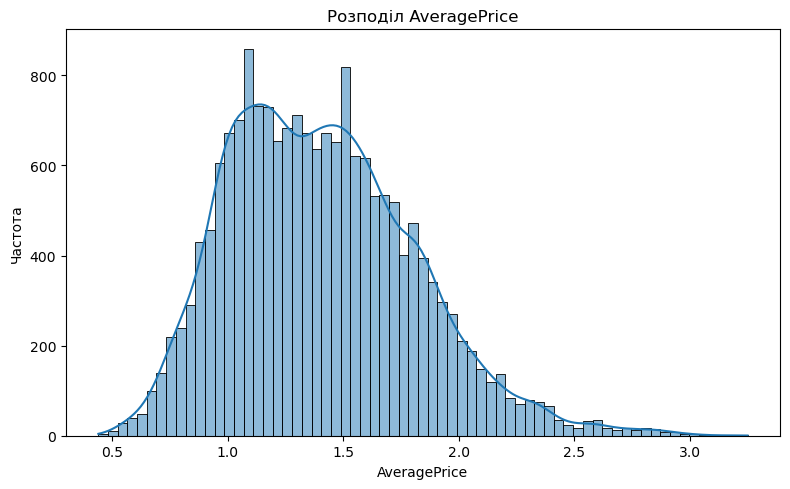

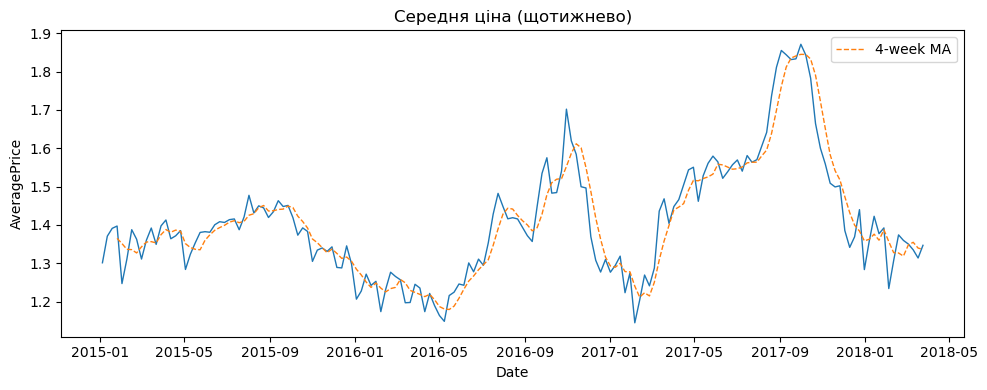

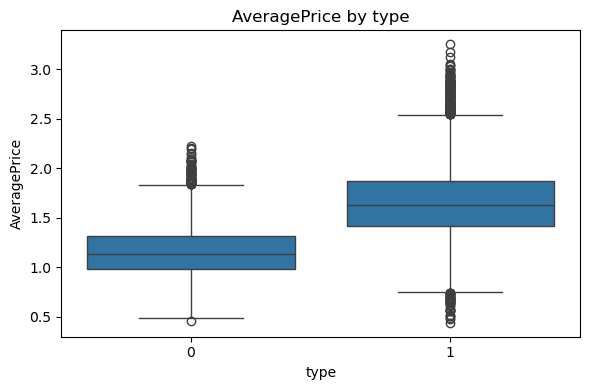

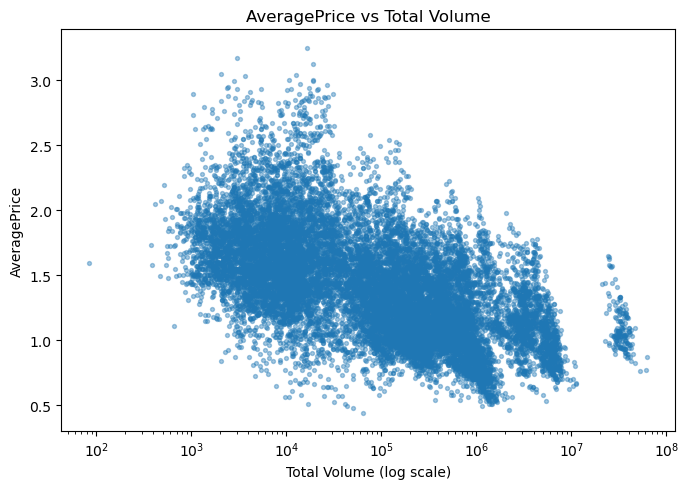

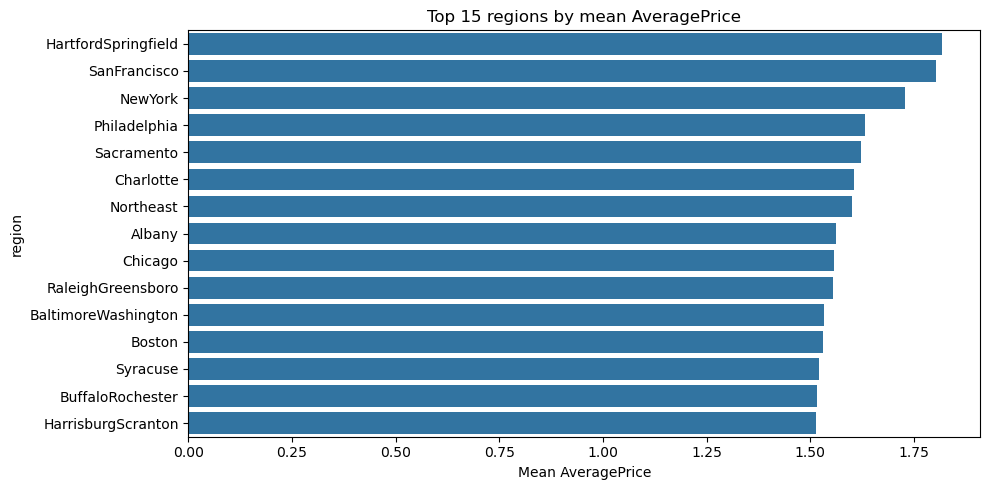

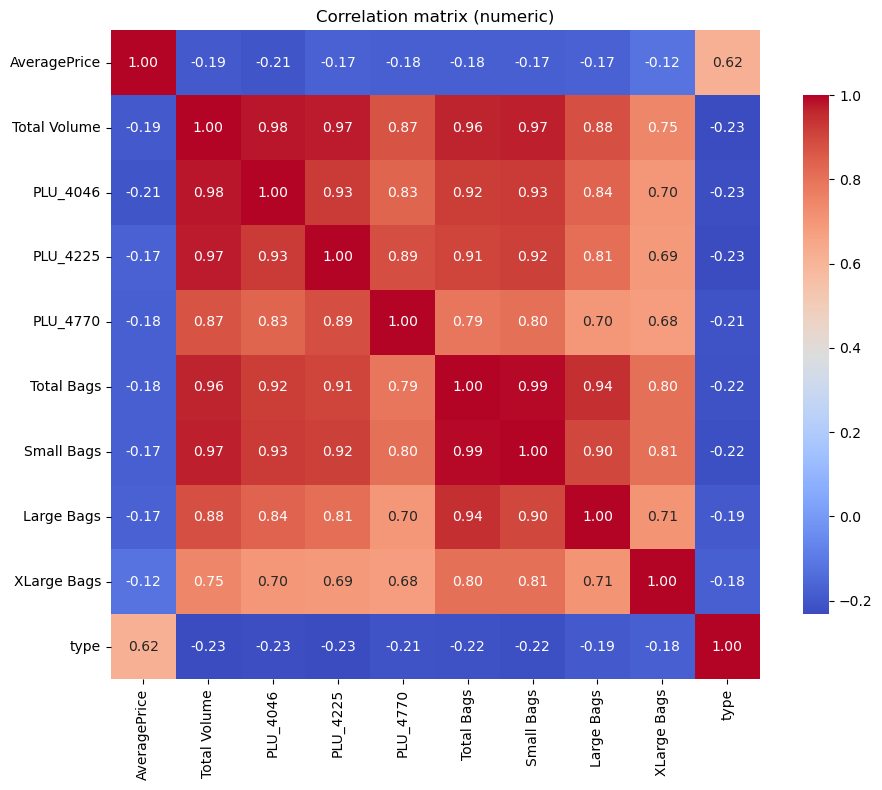

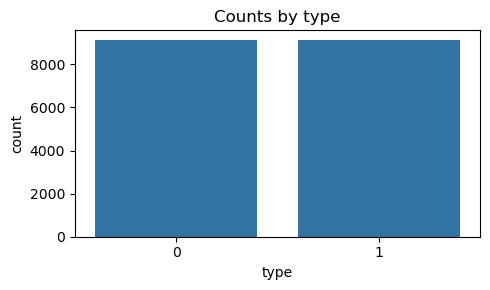

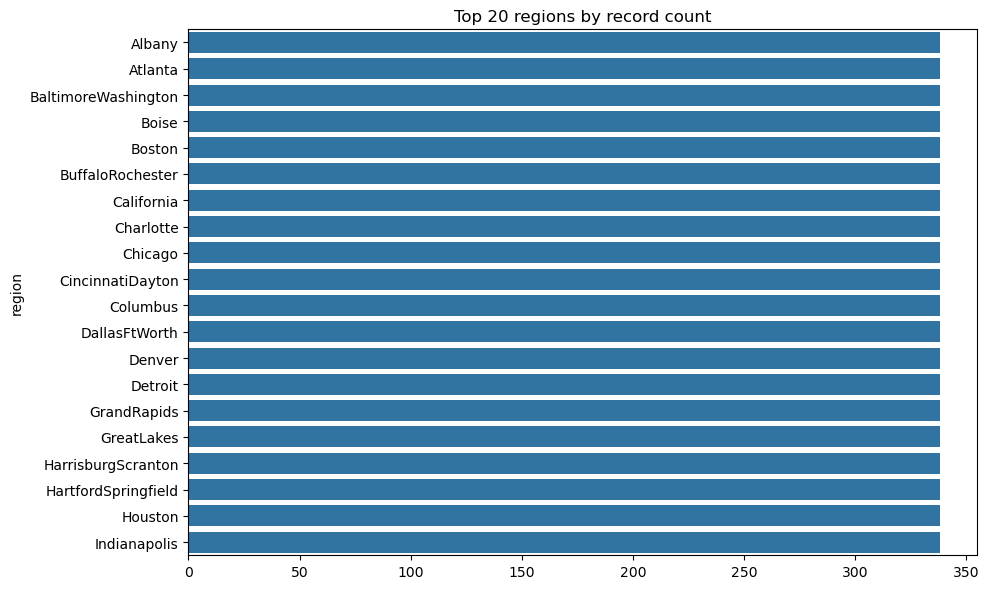

In [ ]:

# ------------------------------
# 2.1. Візуалізація даних
# ------------------------------

# --- 1) Розподіл цільової змінної AveragePrice ---
plt.figure(figsize=(8,5))
sns.histplot(df['AveragePrice'], kde=True)
plt.title('Розподіл AveragePrice')
plt.xlabel('AveragePrice')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

# --- 2) Таймсерія: середня ціна по датам (щотижнева) ---
if 'Date' in df.columns:
    ts = df.set_index('Date').resample('W')['AveragePrice'].mean()
    plt.figure(figsize=(10,4))
    plt.plot(ts.index, ts.values, linewidth=1)
    # додати 4-тижневу ковзну середню
    plt.plot(ts.index, ts.rolling(4).mean(), linestyle='--', linewidth=1, label='4-week MA')
    plt.title('Середня ціна (щотижнево)')
    plt.ylabel('AveragePrice')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 3) Boxplot AveragePrice за type (conventional/organic) ---
if 'type' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df['type'], y=df['AveragePrice'])
    plt.title('AveragePrice by type')
    plt.xlabel('type')
    plt.ylabel('AveragePrice')
    plt.tight_layout()
    plt.show()

# --- 4) Scatter: AveragePrice vs Total Volume (лог шкала для обсягу) ---
for vol_col in ['Total Volume', 'Total Volume ']:  # варіанти назв
    if vol_col in df.columns:
        plt.figure(figsize=(7,5))
        plt.scatter(df[vol_col], df['AveragePrice'], s=8, alpha=0.4)
        plt.xscale('log')   # об'єм часто має довгий хвіст
        plt.xlabel(vol_col + ' (log scale)')
        plt.ylabel('AveragePrice')
        plt.title('AveragePrice vs ' + vol_col)
        plt.tight_layout()
        plt.show()
        break

# --- 5) Середня ціна по топ-15 регіонах (bar) ---
if 'region' in df.columns:
    top_regions = df.groupby('region')['AveragePrice'].mean().sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_regions.values, y=top_regions.index)
    plt.xlabel('Mean AveragePrice')
    plt.title('Top 15 regions by mean AveragePrice')
    plt.tight_layout()
    plt.show()

# --- 6) Кореляційна матриця (numeric features) ---
num = df.select_dtypes(include=['number']).copy()
if 'AveragePrice' in num.columns:
    plt.figure(figsize=(10,8))
    corr = num.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', square=True, cmap='coolwarm', cbar_kws={'shrink':.8})
    plt.title('Correlation matrix (numeric)')
    plt.tight_layout()
    plt.show()

# --- 7) Частоти / розподіли категорій (type / region counts) ---
if 'type' in df.columns:
    plt.figure(figsize=(5,3))
    sns.countplot(x='type', data=df)
    plt.title('Counts by type')
    plt.tight_layout()
    plt.show()

# region може бути багато — показати топ-20 по частоті
if 'region' in df.columns:
    region_counts = df['region'].value_counts().head(20)
    plt.figure(figsize=(10,6))
    sns.barplot(x=region_counts.values, y=region_counts.index)
    plt.title('Top 20 regions by record count')
    plt.tight_layout()
    plt.show()


In [65]:
"""


TARGET = 'AveragePrice'

# Перевірка наявності файлу
if not Path('data/avocado.csv').exists():
    raise FileNotFoundError(f"Файл не знайдено: {Path('data/avocado.csv').resolve()}")

# Переконайся, що папка для збереження існує
out_dir = Path('data/avocado_prepared.csv' ).parent
out_dir.mkdir(parents=True, exist_ok=True)


# Завантажити дані та перевірити структуру 
if not os.path.exists('data/avocado.csv'):
    raise FileNotFoundError(f"Файл не знайдено: {'data/avocado.csv'}")

df = pd.read_csv('data/avocado.csv')

# Показати імена стовпців
print("Стовпці датасету:")
print(df.columns.tolist())
print("\n")

# Показати інформацію про датасет
print("Інформація про датасет:")
df.info()
print("\n")

# Показати описові статистики
print("Описові статистики:")
print(df.describe())
print("\n")


# Показати перші рядки датасету
print("Перші 5 рядків датасету:")
print(df.head())
print("\n")
"""

'\n\n\nTARGET = \'AveragePrice\'\n\n# Перевірка наявності файлу\nif not Path(\'data/avocado.csv\').exists():\n    raise FileNotFoundError(f"Файл не знайдено: {Path(\'data/avocado.csv\').resolve()}")\n\n# Переконайся, що папка для збереження існує\nout_dir = Path(\'data/avocado_prepared.csv\' ).parent\nout_dir.mkdir(parents=True, exist_ok=True)\n\n\n# Завантажити дані та перевірити структуру \nif not os.path.exists(\'data/avocado.csv\'):\n    raise FileNotFoundError(f"Файл не знайдено: {\'data/avocado.csv\'}")\n\ndf = pd.read_csv(\'data/avocado.csv\')\n\n# Показати імена стовпців\nprint("Стовпці датасету:")\nprint(df.columns.tolist())\nprint("\n")\n\n# Показати інформацію про датасет\nprint("Інформація про датасет:")\ndf.info()\nprint("\n")\n\n# Показати описові статистики\nprint("Описові статистики:")\nprint(df.describe())\nprint("\n")\n\n\n# Показати перші рядки датасету\nprint("Перші 5 рядків датасету:")\nprint(df.head())\nprint("\n")\n'

In [66]:
"""


# Видалити зайві стовпці 
# Часті «службові» назви: 'Unnamed: 0', 'Unnamed:0', 'X' або окремий стовпець year, що дублює дату
drop_candidates = ['Unnamed: 0', 'Unnamed:0', 'X', 'year']
drop_cols = [c for c in drop_candidates if c in df.columns]
if drop_cols:
    df.drop(columns=drop_cols, inplace=True)
    print('\nВидалені службові колонки:', drop_cols)

# Конвертувати Date у datetime 
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Якщо є пропуски у Date, краще видалити такі рядки
    n_date_na = df['Date'].isna().sum()
    if n_date_na:
        print(f"\nПримітка: знайдено {n_date_na} рядків з некоректною датою. Видаляю їх.")
        df = df.dropna(subset=['Date']).reset_index(drop=True)
    # Додаткові часові ознаки
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['day'] = df['Date'].dt.day
    print('\nСтворено часові ознаки: year, month, dayofweek, day')
else:
    print('\nУ датасеті відсутня колонка Date')

# Кодування категорій (type, region) 
cat_cols = [c for c in ['type', 'region'] if c in df.columns]
if cat_cols:
    # Використаємо get_dummies для простоти. drop_first=True щоб уникнути мультиколінеарності.
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    print(f"\nЗакодовані категоріальні колонки: {cat_cols} -> one-hot (drop_first=True)")
else:
    print('\nКатегоріальних колонок type/region не знайдено для кодування')


# Перейменувати колонки 4046, 4225, 4770 (PLU-коди) 
plu_codes = ['4046', '4225', '4770']
# Стовпці можуть бути рядками або числами. Зробимо універсальне перейменування.
rename_map = {}
for col in df.columns:
    col_str = str(col)
    if col_str in plu_codes:
        rename_map[col] = f'plu_{col_str}'
if rename_map:
    df.rename(columns=rename_map, inplace=True)
    print('\nПерейменовано PLU-колонки:', rename_map)
else:
    print('\nPLU-колонки 4046/4225/4770 не знайдено або вже перейменовано')

# Очищення даних: пропуски та дублікатні рядки 
# Пропуски
missing = df.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    print('\nЗнайдені пропуски по колонках:')
    print(missing)
    # Для числових колонок заповнюємо медіаною, для категоріальних - модою
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Не чіпаємо ціль, якщо у ній є пропуски - це краще розглянути окремо
    if TARGET in num_cols:
        num_cols.remove(TARGET)
    for c in missing.index:
        if c in num_cols:
            med = df[c].median()
            df[c].fillna(med, inplace=True)
            print(f"Заповнено пропуски в числовій колонці {c} медианою: {med}")
        else:
            mode = df[c].mode()
            if not mode.empty:
                df[c].fillna(mode.iloc[0], inplace=True)
                print(f"Заповнено пропуски в колонці {c} модою: {mode.iloc[0]}")
            else:
                df[c].fillna('', inplace=True)
                print(f"Заповнено пропуски в колонці {c} пустим рядком")
else:
    print('\nПропусків у датасеті не знайдено')

# Дублікатні рядки
n_dup = df.duplicated().sum()
if n_dup:
    print(f"\nЗнайдено {n_dup} дублікатів. Видаляю...")
    df.drop_duplicates(inplace=True)
else:
    print('\nДублікатів не знайдено')

# Масштабувати числові ознаки 
# Для SVR масштабування важливе. Масштабуємо всі числові колонки, крім цільової TARGET.
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in num_cols:
    num_cols.remove(TARGET)

if num_cols:
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    print('\nМасштабовано числові ознаки (StandardScaler). Кількість колонок:', len(num_cols))
else:
    print('\nЧислових колонок для масштабування не знайдено')



"""

'\n\n\n# Видалити зайві стовпці \n# Часті «службові» назви: \'Unnamed: 0\', \'Unnamed:0\', \'X\' або окремий стовпець year, що дублює дату\ndrop_candidates = [\'Unnamed: 0\', \'Unnamed:0\', \'X\', \'year\']\ndrop_cols = [c for c in drop_candidates if c in df.columns]\nif drop_cols:\n    df.drop(columns=drop_cols, inplace=True)\n    print(\'\nВидалені службові колонки:\', drop_cols)\n\n# Конвертувати Date у datetime \nif \'Date\' in df.columns:\n    df[\'Date\'] = pd.to_datetime(df[\'Date\'], errors=\'coerce\')\n    # Якщо є пропуски у Date, краще видалити такі рядки\n    n_date_na = df[\'Date\'].isna().sum()\n    if n_date_na:\n        print(f"\nПримітка: знайдено {n_date_na} рядків з некоректною датою. Видаляю їх.")\n        df = df.dropna(subset=[\'Date\']).reset_index(drop=True)\n    # Додаткові часові ознаки\n    df[\'year\'] = df[\'Date\'].dt.year\n    df[\'month\'] = df[\'Date\'].dt.month\n    df[\'dayofweek\'] = df[\'Date\'].dt.dayofweek\n    df[\'day\'] = df[\'Date\'].dt.day\n 